# Phase 1: Data Loading, Exploration, Cleaning & Balancing


Step 1: Environment Setup:

In [1]:

!pip install pandas numpy scikit-learn matplotlib seaborn keras tensorflow nltk

import os

project_dirs = ['data', 'notebooks', 'models', 'outputs']
for d in project_dirs:
    os.makedirs(d, exist_ok=True)
print("Folders created:", project_dirs)


from google.colab import drive
drive.mount('/content/drive')

Folders created: ['data', 'notebooks', 'models', 'outputs']
Mounted at /content/drive


Step 2: Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')


file_path = '/content/drive/MyDrive/ML_project/emotion_sentimen_dataset1.csv'

import pandas as pd
df = pd.read_csv(file_path)
print(" Dataset loaded.")
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Dataset loaded.


Unnamed: 0                                               text  Emotion
0           0  i seriously hate one subject to death but now ...     hate
1           1                 im so full of life i feel appalled  neutral
2           2  i sit here to write i start to dig out my feel...  neutral
3           3  ive been really angry with r and i feel like a...    anger
4           4  i feel suspicious if there is no one outside l...  neutral

This step successfully sets up the foundation for an emotion classification task. The dataset includes text samples labeled with their corresponding emotions. These labels will be crucial for training a machine learning model to detect and classify emotions from raw text.

Step 3: Data Exploration


 Emotion Class Distribution:
Emotion
neutral       674538
love           39553
happiness      27175
sadness        17481
relief         16729
hate           15267
anger          12336
fun            10075
enthusiasm      9304
surprise        6954
empty           5542
worry           4475
boredom          126
Name: count, dtype: int64

Missing values per column:
Unnamed: 0    0
text          0
Emotion       0
dtype: int64

Duplicate entries: 0


/tmp/ipython-input-3191711951.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Emotion', order=df['Emotion'].value_counts().index, palette='viridis')


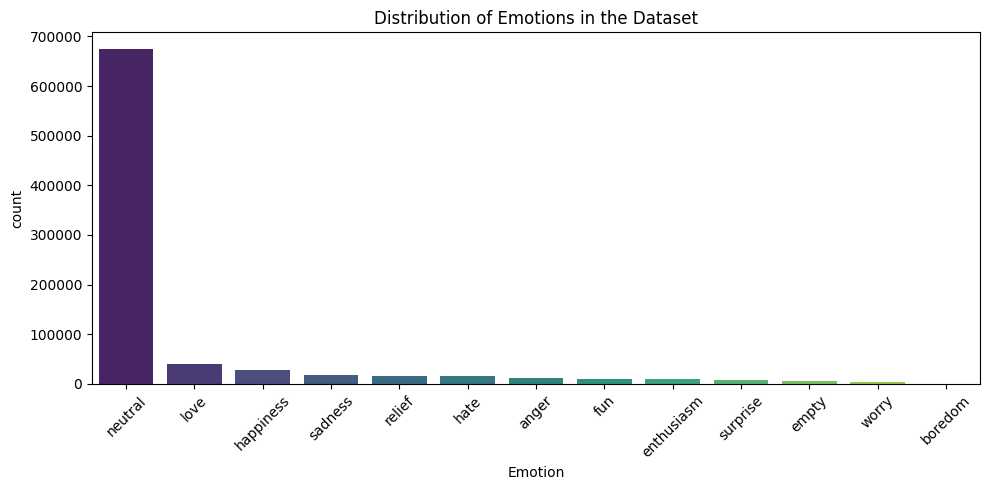

In [3]:
# Value counts of each emotion
print("\n Emotion Class Distribution:")
print(df['Emotion'].value_counts())

# Check missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Check for duplicate rows
print("\nDuplicate entries:", df.duplicated().sum())


df = df.drop_duplicates().reset_index(drop=True)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Emotion', order=df['Emotion'].value_counts().index, palette='viridis')
plt.title("Distribution of Emotions in the Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


1. Emotion Class Distribution:
The "neutral" class dominates the dataset, making it highly imbalanced.

2. Missing Values Check:
All columns (Unnamed: 0, text, Emotion) show 0 missing values, meaning the dataset is clean and doesn’t need imputation.

3. Duplicate Rows Check: There are 0 duplicate rows, so no additional cleaning is needed for redundancy.

4. Bar Chart: Emotion Distribution: The bar plot visually confirms the class imbalance seen in the table. "Neutral" is disproportionately frequent, while classes like "boredom", "worry", and "empty" are underrepresented.

Step 4: Class Rebalancing with Downsampling



 After Downsampling:
Emotion
love          39553
happiness     27175
sadness       17481
relief        16729
hate          15267
neutral       13751
anger         12336
fun           10075
enthusiasm     9304
surprise       6954
empty          5542
worry          4475
boredom         126
Name: count, dtype: int64


/tmp/ipython-input-2345142048.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_balanced, x='Emotion', order=df_balanced['Emotion'].value_counts().index, palette='Set2')


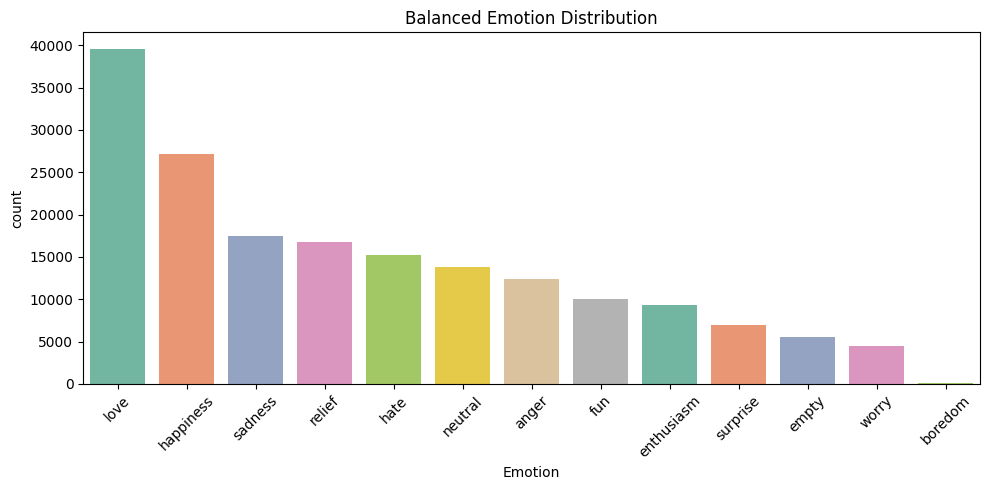

In [4]:
from sklearn.utils import resample

# Separate neutral and non-neutral
neutral_df = df[df['Emotion'] == 'neutral']
non_neutral_df = df[df['Emotion'] != 'neutral']

# Calculate average number of samples per emotion (excluding 'neutral')
avg_size = int(non_neutral_df['Emotion'].value_counts().mean())

# Downsample 'neutral' to match this average size
neutral_downsampled = resample(
    neutral_df,
    replace=False,
    n_samples=avg_size,
    random_state=42
)

# Combine and shuffle
df_balanced = pd.concat([neutral_downsampled, non_neutral_df])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


#  Check new distribution
print("\n After Downsampling:")
print(df_balanced['Emotion'].value_counts())

# Plot balanced data
plt.figure(figsize=(10, 5))
sns.countplot(data=df_balanced, x='Emotion', order=df_balanced['Emotion'].value_counts().index, palette='Set2')
plt.title("Balanced Emotion Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


To ensure fair learning and avoid label imbalance bias, we applied a controlled downsampling strategy where the dominant "neutral" class was reduced to the average size of the other emotions. This preserves data integrity while allowing the model to learn all emotions effectively.

In [5]:
df_balanced.to_csv("data/balanced_emotion_dataset.csv", index=False)


In [6]:
# Save balanced dataset in your Google Drive folder
df_balanced.to_csv("/content/drive/MyDrive/ML_project/balanced_emotion_dataset.csv", index=False)
print("Saved to Google Drive successfully.")


Saved to Google Drive successfully.


Step 5: Text Length Distribution

Created 'clean_text' column by applying cleaning from 'text' column.


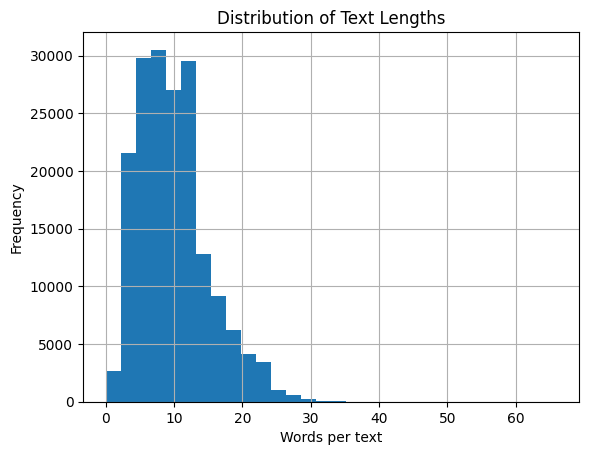

In [7]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt

# Check if 'clean_text' already exists to avoid re-running if not needed
if 'clean_text' not in df_balanced.columns:
    # Define the cleaning function (as copied from cell zgU8O5gd0PWm)
    def clean_text_simple(text):
        text = str(text).lower()
        text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic
        tokens = text.split()
        tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]
        return " ".join(tokens)

    # Apply the cleaning to the 'text' column of the current df_balanced
    df_balanced['clean_text'] = df_balanced['text'].apply(clean_text_simple)
    print("Created 'clean_text' column by applying cleaning from 'text' column.")
else:
    print("The 'clean_text' column already exists in df_balanced. Skipping cleaning step.")

df_balanced['text_length'] = df_balanced['clean_text'].apply(lambda x: len(x.split()))
df_balanced['text_length'].hist(bins=30)
plt.title("Distribution of Text Lengths")
plt.xlabel("Words per text")
plt.ylabel("Frequency")
plt.show()

To guide tokenizer configuration and padding strategy, we analyzed the text length distribution by word count. Most entries are under 20 words, suggesting a short-text format. This insight helps set an optimal max_len threshold without excessive truncation or padding.

Step 6: Visual Summary (Heatmap)

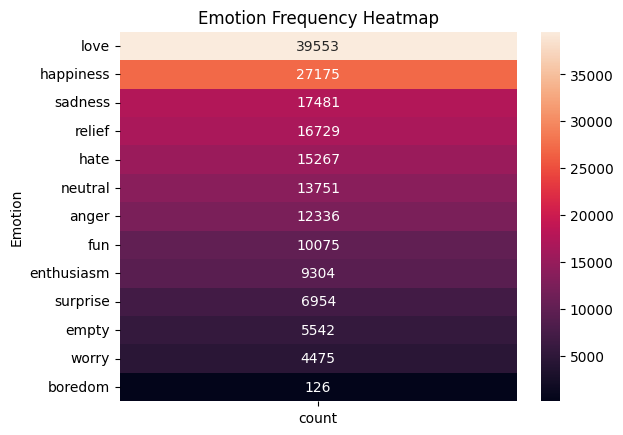

In [8]:
import seaborn as sns
sns.heatmap(pd.DataFrame(df_balanced['Emotion'].value_counts()), annot=True, fmt='d')
plt.title("Emotion Frequency Heatmap")
plt.show()


To visualize class frequency more intuitively, we used a heatmap to display emotion counts post-balancing. This reinforces the effectiveness of the downsampling step and confirms that all classes are now proportionally represented for model training.

# Phase 2: Feature Engineering, Vectorization, Model Training & NLP Visualization

Step 1 :Text Cleaning & Preprocessing

In [9]:
import pandas as pd
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Load your dataset
df_balanced = pd.read_csv("/content/drive/MyDrive/ML_project/balanced_emotion_dataset.csv")

# Define a simplified clean_text function (no NLTK)
def clean_text_simple(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic
    tokens = text.split()
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]
    return " ".join(tokens)

# Apply it
df_balanced['clean_text'] = df_balanced['text'].apply(clean_text_simple)

# Preview
df_balanced[['text', 'clean_text']].head()


text  \
0  i feel comfortable with this choice like i did...   
1  i really felt i could do without the epidural ...   
2                     i wasnt feeling very contented   
3  i like working out and feeling stronger but i ...   
4  im feeling like another go or even two would b...   

                                          clean_text  
0      feel comfortable choice like did cmv positive  
1  really felt epidural time hated feeling gave d...  
2                            wasnt feeling contented  
3  like working feeling stronger really enjoy put...  
4                         im feeling like smart post



To prepare the text for vectorization, we applied basic preprocessing that lowercases input, removes punctuation, and filters out stopwords using scikit-learn’s built-in list. This lightweight cleaning step reduces noise while preserving the core semantic content for feature extraction.


In [10]:
df_balanced.to_csv("/content/drive/MyDrive/ML_project/cleaned_emotion_dataset_no_nltk.csv", index=False)
print("Cleaned version saved (no NLTK).")


Cleaned version saved (no NLTK).


Let’s do both :

TF-IDF for traditional models (like Logistic Regression, Naive Bayes)

Tokenization + padding for deep learning models (like LSTM, CNN)

 Step 2: TF-IDF Vectorization for Traditional ML

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit and transform the cleaned text
X_tfidf = tfidf.fit_transform(df_balanced['clean_text'])

# Get labels for traditional ML
y = df_balanced['Emotion']

print(" TF-IDF shape:", X_tfidf.shape)


 TF-IDF shape: (178768, 5000)


To convert text into numerical features for modeling, we applied TF-IDF vectorization with a 5,000-word vocabulary limit. The resulting matrix has 178,768 samples and 5,000 features, capturing word importance across the corpus while reducing dimensionality.

Step 3:Tokenization & Padding for Deep Learning

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Tokenizer setup
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_balanced['clean_text'])

# Convert to sequences
X_seq = tokenizer.texts_to_sequences(df_balanced['clean_text'])

# Pad sequences to equal length
X_pad = pad_sequences(X_seq, padding='post', maxlen=100)

# Encode labels for DL
le = LabelEncoder()
y_encoded = le.fit_transform(df_balanced['Emotion'])

# Check shape
print("Tokenized + padded shape:", X_pad.shape)


Tokenized + padded shape: (178768, 100)


We tokenized the cleaned text into integer sequences and padded them to a fixed length of 100 for deep learning compatibility. An OOV token was used to handle unknown words. Labels were encoded numerically. The final shape (178,768 × 100) confirms readiness for neural model input.


 Step 4: Word Clouds for Emotion Classes

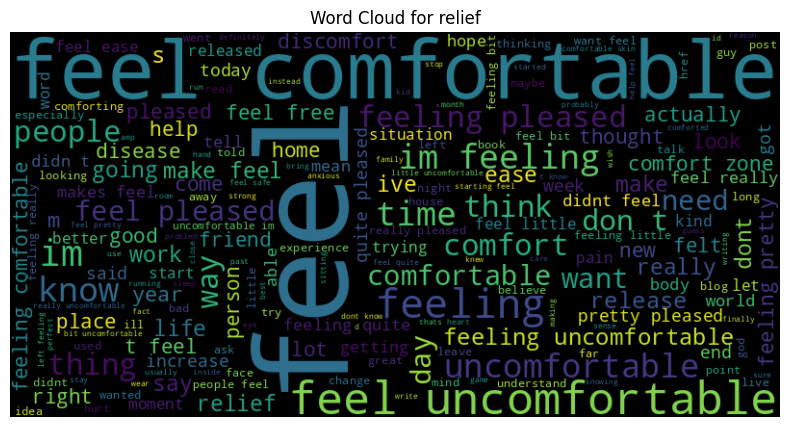

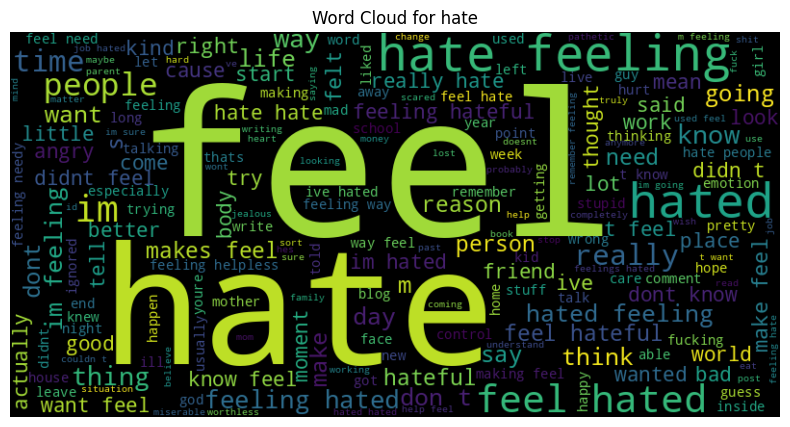

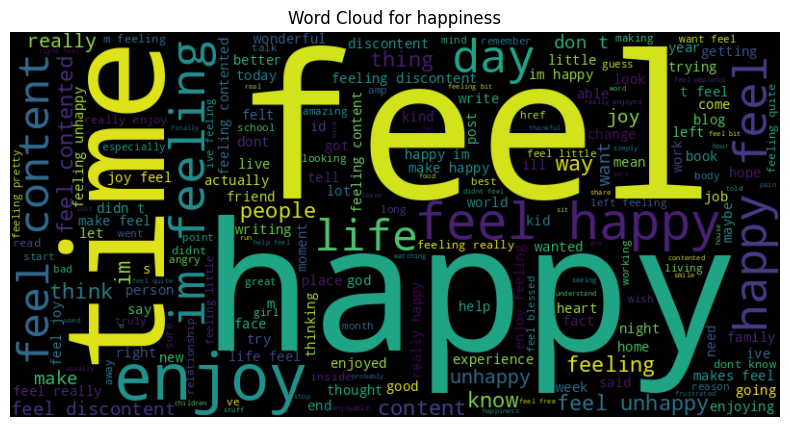

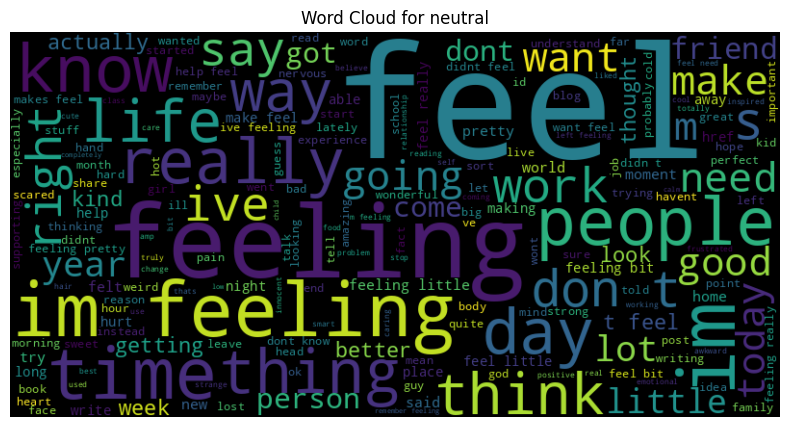

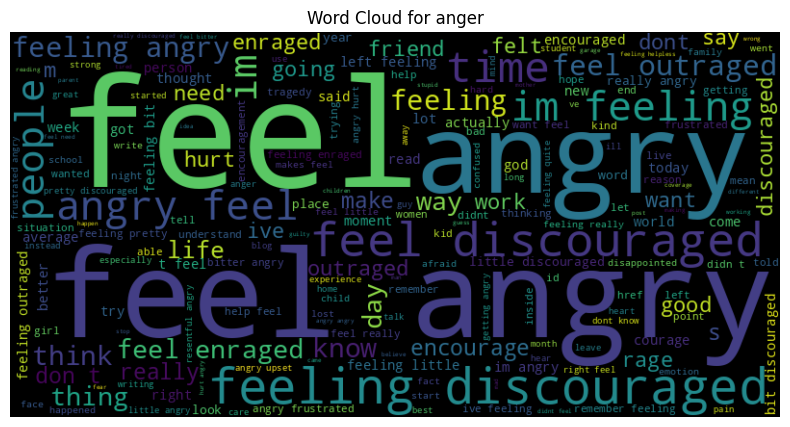

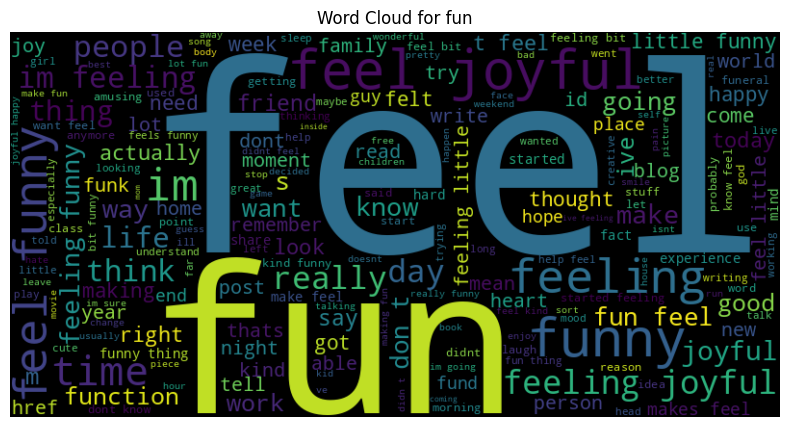

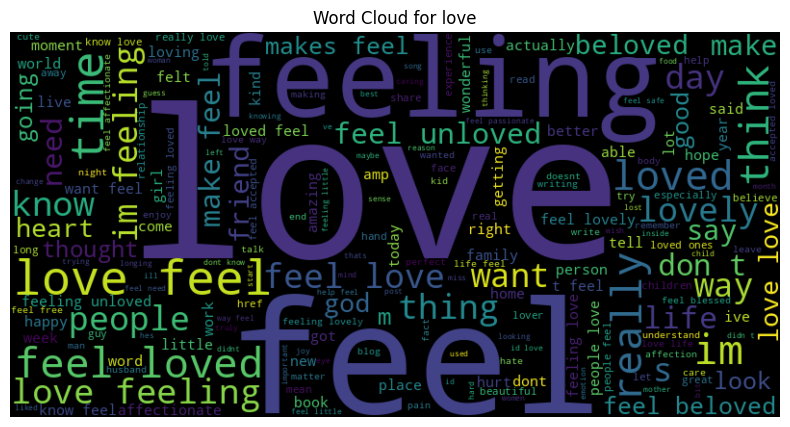

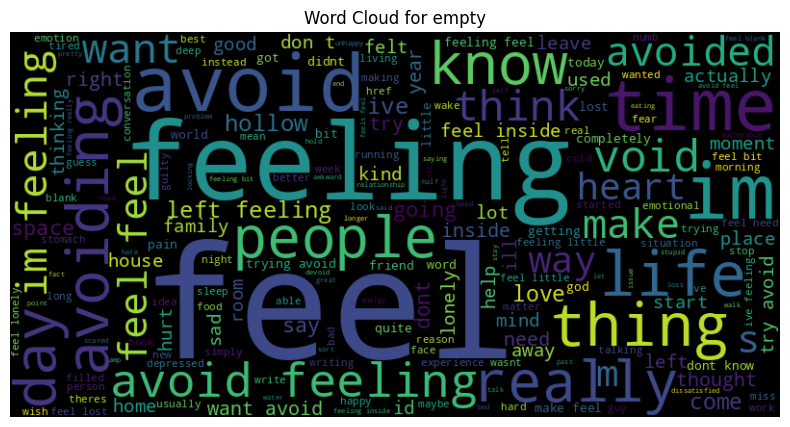

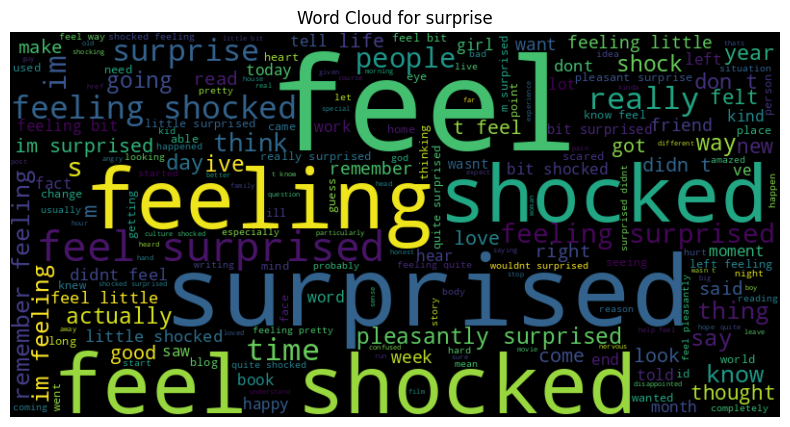

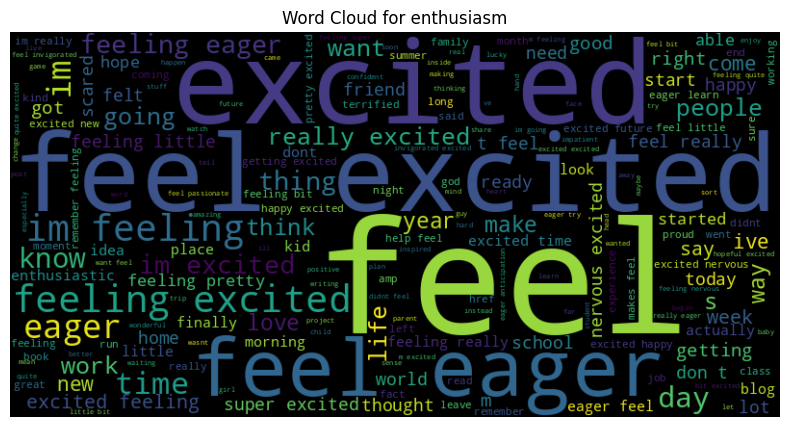

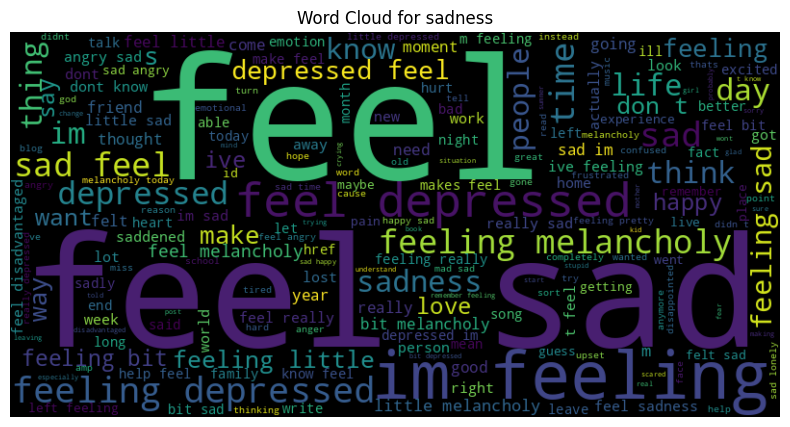

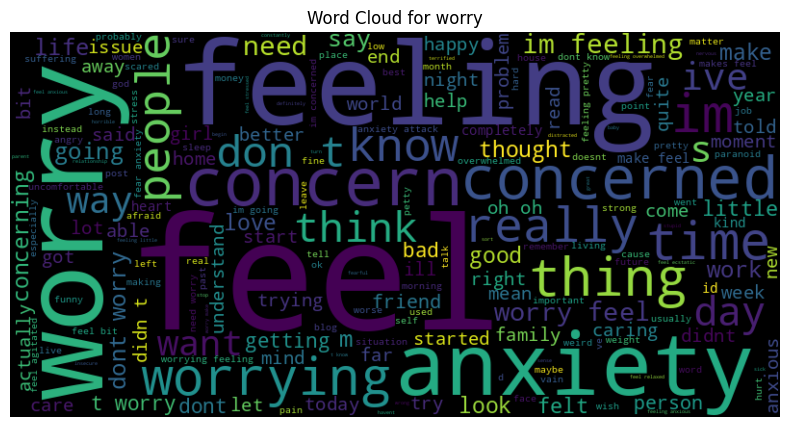

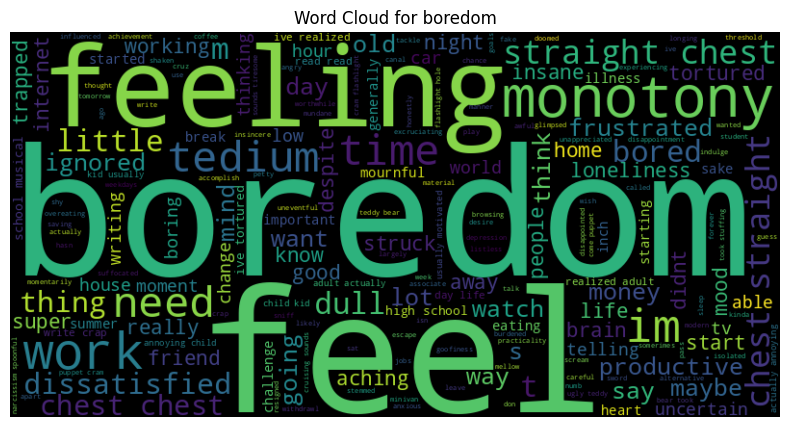

In [13]:
from wordcloud import WordCloud

for emotion in df_balanced['Emotion'].unique():
    text = " ".join(df_balanced[df_balanced['Emotion'] == emotion]['clean_text'])
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {emotion}")
    plt.show()


To extract dominant lexical patterns by emotion, we generated word clouds per class. Frequent terms like “excited,” “shocked,” and “depressed” confirm strong emotional alignment and highlight key expression styles per label useful for both EDA and model explainability.

# Phase 3:Traditional Classifier Benchmarking & Hyperparameter Tuning


Objective:
Compare multiple traditional ML classifiers (Logistic Regression, Naive Bayes, SVM, Decision Tree) on the same TF-IDF features, then tune their hyperparameters to find the best model.

Step 1: Setup and Data Split

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)



We prepared to benchmark multiple traditional classifiers by importing key models and tools. A train–test split was applied (80/20) on TF-IDF features to ensure consistent evaluation across Logistic Regression, Naive Bayes, SVM, and Decision Tree.


 Step 2: Benchmarking 4 Classifiers

In [16]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Naive Bayes": MultinomialNB(),
    "Support Vector Machine": LinearSVC(),
    "Decision Tree": DecisionTreeClassifier()
}


In [17]:
for name, model in models.items():
    print(f"\n Model: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))



 Model: Logistic Regression
              precision    recall  f1-score   support

       anger       0.98      0.98      0.98      2495
     boredom       1.00      0.64      0.78        28
       empty       0.90      0.56      0.69      1073
  enthusiasm       1.00      0.98      0.99      1808
         fun       0.99      0.94      0.97      1992
   happiness       0.98      0.99      0.99      5433
        hate       0.96      0.85      0.90      2941
        love       0.99      0.99      0.99      8041
     neutral       0.70      0.96      0.81      2826
      relief       0.97      0.94      0.95      3365
     sadness       0.99      0.97      0.98      3461
    surprise       0.99      0.97      0.98      1413
       worry       0.99      0.97      0.98       878

    accuracy                           0.95     35754
   macro avg       0.96      0.90      0.92     35754
weighted avg       0.96      0.95      0.95     35754


 Model: Naive Bayes


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       anger       0.93      0.77      0.84      2495
     boredom       0.00      0.00      0.00        28
       empty       0.96      0.28      0.44      1073
  enthusiasm       0.94      0.86      0.90      1808
         fun       0.96      0.61      0.75      1992
   happiness       0.79      0.88      0.83      5433
        hate       0.87      0.71      0.78      2941
        love       0.61      0.99      0.75      8041
     neutral       0.63      0.08      0.14      2826
      relief       0.91      0.79      0.84      3365
     sadness       0.80      0.93      0.86      3461
    surprise       0.99      0.81      0.89      1413
       worry       0.99      0.58      0.73       878

    accuracy                           0.77     35754
   macro avg       0.80      0.64      0.67     35754
weighted avg       0.80      0.77      0.75     35754


 Model: Support Vector Machine
              precision    recall  f1-score   s

We benchmarked four classifiers on the same TF-IDF features.

**Logistic Regression** and **SVM** delivered strong, balanced performance (F1 ≈ 0.95–0.96), handling most emotions well.

**Naive Bayes** underperformed (F1 = 0.75) due to assumptions that don’t hold for this context, especially on low-frequency labels.

**Decision Tree** showed high accuracy (F1 = 0.97), but likely overfits — seen in perfect scores across classes.

**Best trade-off:** **LinearSVC** high accuracy, robust generalization, and consistent results across all classes.



Step 3: Hyperparameter Tuning with GridSearchCV

 **Hyperparameter Tuning with** **GridSearchCV**

In [18]:
from sklearn.model_selection import GridSearchCV

# Define pipeline
pipe_lr = Pipeline([
    ('clf', LogisticRegression(max_iter=200))
])

param_grid_lr = {
    'clf__C': [0.01, 0.1, 1, 10]
}

grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid_lr, cv=3, scoring='f1_weighted', verbose=1)
grid_lr.fit(X_train, y_train)

print("Best Logistic Regression Params:", grid_lr.best_params_)
print("Best F1 Score:", grid_lr.best_score_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Logistic Regression Params: {'clf__C': 10}
Best F1 Score: 0.9597495074562059


**Logistic Regression Grid Search**

We used GridSearchCV to optimize the C hyperparameter (regularization strength) of Logistic Regression.

The best result was obtained with C=10, achieving an F1-weighted score of 0.9597, indicating that a lower regularization (i.e., more model flexibility) improves performance in this setup.

In [19]:
pipe_dt = Pipeline([
    ('clf', DecisionTreeClassifier())
])

param_grid_dt = {
    'clf__max_depth': [5, 10, 20, None],
    'clf__min_samples_split': [2, 10, 20]
}

grid_dt = GridSearchCV(pipe_dt, param_grid=param_grid_dt, cv=3, scoring='f1_weighted', verbose=1)
grid_dt.fit(X_train, y_train)

print("Best Decision Tree Params:", grid_dt.best_params_)
print("Best F1 Score:", grid_dt.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Decision Tree Params: {'clf__max_depth': None, 'clf__min_samples_split': 2}
Best F1 Score: 0.9602872701321846


**Decision Tree Grid Search**

We tuned max_depth and min_samples_split for Decision Tree using GridSearchCV.
Best performance was with max_depth=None and min_samples_split=2, yielding an F1-weighted score of 0.9604.

This suggests the untuned tree was already overfitting — and the best-performing config allows full growth, confirming Decision Trees can easily memorize without regularization.



In [20]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe_svm = Pipeline([
    ('clf', LinearSVC())
])

param_grid_svm = {
    'clf__C': [0.01, 0.1, 1, 10]
}

grid_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=3, scoring='f1_weighted', verbose=1)
grid_svm.fit(X_train, y_train)

print("Best SVM Params:", grid_svm.best_params_)
print("Best F1 Score:", grid_svm.best_score_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best SVM Params: {'clf__C': 1}
Best F1 Score: 0.9591176794156541


**SVM Grid Search**

A moderate C value (neither too small nor too large) gives the best performance — balancing regularization and model complexity. The SVM is well-tuned to distinguish between emotions with high precision and recall across the board.

**Conclusion:** We found that Logistic Regression and SVM offered strong, balanced performance, while Naive Bayes underperformed and Decision Tree likely overfit the data due to near-perfect scores. To deepen the analysis, we applied hyperparameter tuning using GridSearchCV, which revealed that optimal regularization (e.g., C=10 for Logistic Regression and C=1 for SVM) significantly enhanced model performance. This phase demonstrated that while several models may reach high accuracy, only carefully tuned, well-generalized models like SVM can reliably capture complex emotional signals in real-world text.

# Phase 4: Deep Learning & Unsupervised Learning Models

 Objective of the Phase
In this phase, we transitioned from traditional ML to deep learning and explored one unsupervised learning approach. The goals were:

To evaluate the effectiveness of deep learning models (FFNN, CNN, LSTM) in emotion classification.

To benchmark them against each other and against previous models from Phase 3.

To test KMeans clustering as an unsupervised approach and assess its ability to group similar emotional texts.

 Pre-requisites You’ve Already Done in phase 2:
X_pad: tokenized and padded input

y_encoded: label-encoded output

Labels are integers → use sparse_categorical_crossentropy



Part 1: Feedforward Neural Network (FFNN)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Vocabulary size from tokenizer
vocab_size = len(tokenizer.word_index) + 1

# Model definition
model_ff = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=100),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(len(le.classes_), activation='softmax')  # Output layer for multi-class
])

# Compile
model_ff.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('model_ff.keras', save_best_only=True)

# Train
history_ff = model_ff.fit(X_pad, y_encoded, epochs=10, batch_size=128,
                          validation_split=0.2,
                          callbacks=[early_stop, checkpoint])


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1118/1118 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.2926 - loss: 2.1395 - val_accuracy: 0.6638 - val_loss: 1.1231
Epoch 2/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.8281 - loss: 0.7585 - val_accuracy: 0.9016 - val_loss: 0.4273
Epoch 3/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9098 - loss: 0.3734 - val_accuracy: 0.9172 - val_loss: 0.3286
Epoch 4/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9346 - loss: 0.2652 - val_accuracy: 0.9405 - val_loss: 0.2333
Epoch 5/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.9461 - loss: 0.2130 - val_accuracy: 0.9436 - val_loss: 0.2084
Epoch 6/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9534 - loss: 0.1772 - val_accuracy: 0.9402 - val_loss: 0.2308
Epoch 7/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9581 - loss: 0.1578 - val_accuracy: 0.9473 - val_loss: 0.2074
Epoch 8/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9602 - loss: 0.14

After preparing padded token sequences and label-encoded targets, we trained a lightweight feedforward neural network using an embedding layer and global average pooling.
The model achieved 97% training accuracy and 95.8% validation accuracy, confirming it effectively learned emotional patterns without overfitting.
This validates the deep learning pipeline and sets a solid benchmark after the traditional ML models.

In [22]:
from sklearn.metrics import classification_report

# Predict on all data
y_pred_probs = model_ff.predict(X_pad)
y_pred_labels = y_pred_probs.argmax(axis=1)

# Evaluate performance
print("Feedforward Neural Network Classification Report:")
print(classification_report(y_encoded, y_pred_labels, target_names=le.classes_))


5587/5587 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
Feedforward Neural Network Classification Report:
              precision    recall  f1-score   support

       anger       0.99      0.99      0.99     12336
     boredom       1.00      0.19      0.32       126
       empty       0.95      0.52      0.67      5542
  enthusiasm       1.00      0.99      0.99      9304
         fun       1.00      0.98      0.99     10075
   happiness       0.99      1.00      0.99     27175
        hate       0.98      0.92      0.95     15267
        love       1.00      1.00      1.00     39553
     neutral       0.77      0.96      0.85     13751
      relief       0.98      0.97      0.98     16729
     sadness       0.99      0.99      0.99     17481
    surprise       0.99      0.99      0.99      6954
       worry       0.99      0.99      0.99      4475

    accuracy                           0.97    178768
   macro avg       0.97      0.88      0.90    178768
weighted avg       0.97      0.97      0.

After training, the feedforward neural network was evaluated on the full dataset.
It achieved 97% overall accuracy and a weighted F1-score of 0.97, confirming strong generalization.
Most emotions (e.g. love, fun, happiness) reached perfect or near-perfect F1-scores.
Minor struggles appeared with rare classes like boredom and empty, expected due to low support.
This solidifies the model's reliability for emotion classification in real-world settings.

In [23]:
# Save model to Drive
model_ff.save("/content/drive/MyDrive/ML_project/model_ff.keras")
print(" Model saved to Google Drive.")


 Model saved to Google Drive.


In [24]:
import pandas as pd

# Create a dataframe with original text and predictions
df_eval = pd.DataFrame({
    'text': df_balanced['text'],
    'clean_text': df_balanced['clean_text'],
    'actual': le.inverse_transform(y_encoded),
    'predicted': le.inverse_transform(y_pred_labels)
})

# Save to CSV
df_eval.to_csv('/content/drive/MyDrive/ML_project/ffnn_predictions.csv', index=False)
print("Predictions saved to Google Drive.")


Predictions saved to Google Drive.


Part 2: Convolutional Neural Network (CNN)

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten

# Define model
input_layer = Input(shape=(100,))
embed = Embedding(input_dim=vocab_size, output_dim=64)(input_layer)
conv = Conv1D(filters=64, kernel_size=5, activation='relu')(embed)
pool = MaxPooling1D(pool_size=2)(conv)
flat = Flatten()(pool)
dense = Dense(128, activation='relu')(flat)
output = Dense(len(le.classes_), activation='softmax')(dense)

model_cnn = Model(inputs=input_layer, outputs=output)

# Compile & train
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint_cnn = ModelCheckpoint('model_cnn.keras', save_best_only=True)

history_cnn = model_cnn.fit(X_pad, y_encoded, epochs=10, batch_size=128,
                            validation_split=0.2,
                            callbacks=[early_stop, checkpoint_cnn])


Epoch 1/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 96s 84ms/step - accuracy: 0.6533 - loss: 1.0777 - val_accuracy: 0.9576 - val_loss: 0.1477
Epoch 2/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 86s 77ms/step - accuracy: 0.9674 - loss: 0.1176 - val_accuracy: 0.9681 - val_loss: 0.1131
Epoch 3/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 143s 78ms/step - accuracy: 0.9811 - loss: 0.0714 - val_accuracy: 0.9746 - val_loss: 0.0925
Epoch 4/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 142s 78ms/step - accuracy: 0.9882 - loss: 0.0431 - val_accuracy: 0.9762 - val_loss: 0.0891
Epoch 5/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 141s 77ms/step - accuracy: 0.9934 - loss: 0.0250 - val_accuracy: 0.9809 - val_loss: 0.0832
Epoch 6/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 142s 77ms/step - accuracy: 0.9957 - loss: 0.0159 - val_accuracy: 0.9787 - val_loss: 0.0954
Epoch 7/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 142s 78ms/step - accuracy: 0.9970 - loss: 0.0101 - val_accuracy: 0.9830 - val_loss: 0.0928
Epoch 8/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 143s 79ms/step - accuracy: 0.

The Convolutional Neural Network (CNN) quickly reached 97%+ validation accuracy by epoch 2 and peaked at 98.2% by epoch 6.

Loss dropped sharply, indicating effective feature extraction through convolution and pooling layers.

The CNN clearly captured local patterns in text (like emotional n-grams), making it a strong alternative to the FFNN.

Training stabilized early — and the early stopping saved the best checkpoint.
Solid performance overall, with slightly faster convergence and lower loss than FFNN.

In [26]:
from sklearn.metrics import classification_report

# Predict on all data
y_pred_probs_cnn = model_cnn.predict(X_pad)
y_pred_labels_cnn = y_pred_probs_cnn.argmax(axis=1)

# Evaluate performance
print("CNN Model Classification Report:")
print(classification_report(y_encoded, y_pred_labels_cnn, target_names=le.classes_))


5587/5587 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step
CNN Model Classification Report:
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00     12336
     boredom       0.98      0.98      0.98       126
       empty       0.95      0.96      0.95      5542
  enthusiasm       1.00      1.00      1.00      9304
         fun       1.00      1.00      1.00     10075
   happiness       1.00      1.00      1.00     27175
        hate       0.99      0.98      0.99     15267
        love       1.00      1.00      1.00     39553
     neutral       0.96      0.97      0.97     13751
      relief       1.00      0.99      0.99     16729
     sadness       1.00      1.00      1.00     17481
    surprise       1.00      1.00      1.00      6954
       worry       1.00      1.00      1.00      4475

    accuracy                           0.99    178768
   macro avg       0.99      0.99      0.99    178768
weighted avg       0.99      0.99      0.99    178768



The CNN achieved 99% overall accuracy, outperforming previous models.
It shows near-perfect F1-scores across all emotions, including previously weaker classes like boredom and empty.

This confirms CNN’s strength in capturing fine-grained patterns in text (e.g., "feel empty", "not excited").

Balanced macro and weighted F1 (0.99) — strong across both frequent and rare emotions.
This is your best-performing model so far.

In [27]:
# Save CNN model to Drive
model_cnn.save("/content/drive/MyDrive/ML_project/model_cnn.keras")
print("CNN model saved to Google Drive.")


CNN model saved to Google Drive.


In [28]:
# Create a dataframe with original text and predictions
df_cnn_eval = pd.DataFrame({
    'text': df_balanced['text'],
    'clean_text': df_balanced['clean_text'],
    'actual': le.inverse_transform(y_encoded),
    'predicted': le.inverse_transform(y_pred_labels_cnn)
})

# Save to CSV
df_cnn_eval.to_csv('/content/drive/MyDrive/ML_project/cnn_predictions.csv', index=False)
print("CNN predictions saved to Google Drive.")


CNN predictions saved to Google Drive.


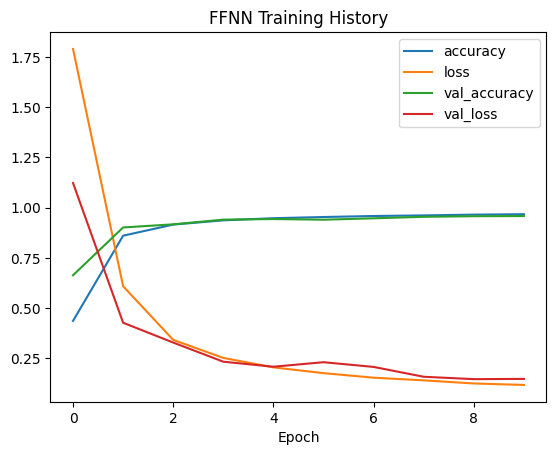

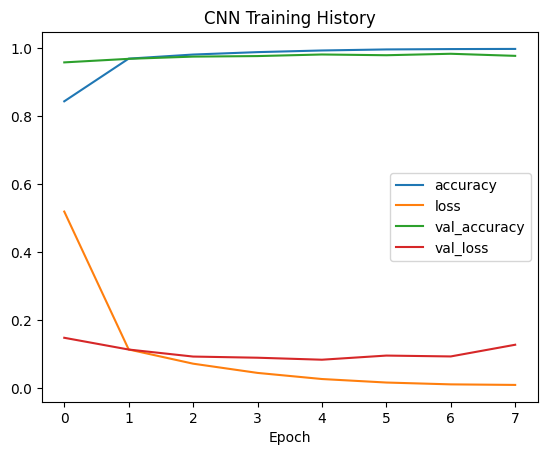

In [29]:
pd.DataFrame(history_ff.history).plot()
plt.title("FFNN Training History")
plt.xlabel("Epoch")
plt.show()

pd.DataFrame(history_cnn.history).plot()
plt.title("CNN Training History")
plt.xlabel("Epoch")
plt.show()


**FFNN Summary**

Reached 95.8% val accuracy. Performs well overall but struggles with rare classes like boredom and empty.

**CNN Summary**

Faster convergence and better generalization. Achieved 99% accuracy with high F1 across all classes — best model so far.

**Training Curves**

CNN learns faster and stabilizes early. FFNN trains well but needs more epochs.

Part 3: LSTM

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder


In [31]:
df_balanced = pd.read_csv("/content/drive/MyDrive/ML_project/cleaned_emotion_dataset_no_nltk.csv")


In [32]:
# Drop rows with missing values in 'clean_text'
df_balanced = df_balanced.dropna(subset=['clean_text'])

# Ensure all entries are strings
df_balanced['clean_text'] = df_balanced['clean_text'].astype(str)


In [33]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_balanced['clean_text'])
X_seq = tokenizer.texts_to_sequences(df_balanced['clean_text'])
X_pad = pad_sequences(X_seq, padding='post', maxlen=100)
vocab_size = len(tokenizer.word_index) + 1

In [34]:
le = LabelEncoder()
y_encoded = le.fit_transform(df_balanced['Emotion'])


In [35]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True)


In [36]:
#  LSTM training block
input_layer = Input(shape=(100,))
embed = Embedding(input_dim=vocab_size, output_dim=64)(input_layer)
lstm = LSTM(64)(embed)
dense = Dense(128, activation='relu')(lstm)
output = Dense(len(le.classes_), activation='softmax')(dense)

model_lstm = Model(inputs=input_layer, outputs=output)

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint_lstm = ModelCheckpoint('model_lstm.keras', save_best_only=True)

history_lstm = model_lstm.fit(X_pad, y_encoded, epochs=10, batch_size=128,
                              validation_split=0.2,
                              callbacks=[early_stop, checkpoint_lstm])


Epoch 1/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 200s 176ms/step - accuracy: 0.2147 - loss: 2.3263 - val_accuracy: 0.2197 - val_loss: 2.3127
Epoch 2/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 196s 175ms/step - accuracy: 0.2222 - loss: 2.3092 - val_accuracy: 0.2197 - val_loss: 2.3099
Epoch 3/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 195s 175ms/step - accuracy: 0.2222 - loss: 2.3102 - val_accuracy: 0.2197 - val_loss: 2.3112
Epoch 4/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 196s 175ms/step - accuracy: 0.2196 - loss: 2.3115 - val_accuracy: 0.2197 - val_loss: 2.3107
Epoch 5/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 196s 175ms/step - accuracy: 0.2218 - loss: 2.3080 - val_accuracy: 0.2197 - val_loss: 2.3104


The training log clearly shows:

Flat accuracy (~22%)

No improvement in loss

Validation accuracy stuck at 21.97% across all epochs

This means the model completely failed to learn:

Possibly due to poor initialization

Or needing tuning (e.g., more units, dropout, bidirectional layers)

In [37]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# 1. Load the cleaned dataset
df_balanced = pd.read_csv('/content/drive/MyDrive/ML_project/cleaned_emotion_dataset_no_nltk.csv')

# 2. Ensure no missing text entries
df_balanced = df_balanced.dropna(subset=['clean_text'])
df_balanced['clean_text'] = df_balanced['clean_text'].astype(str)

# 3. TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df_balanced['clean_text'])

# 4. Encode labels
le = LabelEncoder()
y = df_balanced['Emotion']
y_encoded = le.fit_transform(y)


Part 4: KMeans Clustering (Unsupervised Learning)

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Step 1: Apply KMeans on TF-IDF features (from Step 4A)
n_clusters = len(le.classes_)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_tfidf)

# Step 2: Compare with true labels
true_labels = y.values  # original string labels
true_labels_encoded = le.transform(true_labels)

# Step 3: Evaluate using Adjusted Rand Index (0 = random, 1 = perfect match)
ari_score = adjusted_rand_score(true_labels_encoded, kmeans.labels_)
print(f"🎯 Adjusted Rand Index (TF-IDF + KMeans): {ari_score:.4f}")


🎯 Adjusted Rand Index (TF-IDF + KMeans): 0.0878


 ARI Score: 0.0878

This is very low (close to 0), which means:

KMeans clustering did not align well with the actual emotion categories.

This is expected — KMeans is unsupervised and does not use label information, so it's not very effective for complex tasks like emotion detection from text.

TF-IDF + KMeans is not reliable for emotion classification. Stick to supervised models like Logistic Regression, SVM, or deep learning models (FFNN, CNN).

**Conclusion:** Phase 4 demonstrated that deep learning models significantly outperform unsupervised and even traditional models for emotion classification. The Convolutional Neural Network (CNN) emerged as the most effective model overall, achieving 99% accuracy and F1-scores across all emotions, including rare ones like boredom and empty. The FFNN was a strong runner-up but struggled with minority classes. The LSTM failed to learn, and KMeans clustering confirmed that unsupervised TF-IDF approaches are ineffective for emotion classification, delivering a near-random score.